In [1]:
from datasets import load_dataset
import ollama
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def getResponse(inputString):
    response = ollama.chat(model='llama3.1', messages=[
        {
            'role': 'user',
            'content': inputString,
        }],
        options={'temperature':1.0 }
    )
    return response['message']['content']

ds = load_dataset("SetFit/tweet_sentiment_extraction")
ds

Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['textID', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['textID', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [2]:
answerConversion = {'P': 'positive', 'I': 'neutral', 'N': 'negative'}

def parseOutput(modelOutput):
    if (modelOutput[0] in ['P', 'I', 'N']) and (modelOutput[1:3] == ' -'):
        return answerConversion[modelOutput[0]]
    else:
        return -1

In [36]:
featureEngineering = '''[Instructions]: You are a sentiment analyzer tasked with classifying tweets. Given a question, compute the sentiment as P for Positive, I for neutral (indifferent) and N for negative. Give exactly one classification.
[Format]: Format your answer as: P OR I OR N - EXPLANATION HERE
[Question]: '''
for i in range(10):
    sample = ds['train'][i]
    print('-'*50)
    print(sample['text'])
    modelOutput = getResponse(featureEngineering + sample['text'])
    # print(modelOutput)
    parsedModelOuptut = parseOutput(modelOutput)
    print(f"Correct: {parsedModelOuptut}" if parsedModelOuptut == sample['label_text'] else f'Incorrect. {parsedModelOuptut} != {sample['label_text']}')



--------------------------------------------------
 I`d have responded, if I were going
Incorrect. negative != neutral
--------------------------------------------------
 Sooo SAD I will miss you here in San Diego!!!
Correct: negative
--------------------------------------------------
my boss is bullying me...
Correct: negative
--------------------------------------------------
 what interview! leave me alone
Incorrect. positive != negative
--------------------------------------------------
 Sons of ****, why couldn`t they put them on the releases we already bought
Correct: negative
--------------------------------------------------
http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth
Incorrect. positive != neutral
--------------------------------------------------
2am feedings for the baby are fun when he is all smiles and coos
Correct: positive
--------------------------------------------------
Soooo high
Incorrect. positive != neutral
--------

In [5]:
from collections import defaultdict
ds = load_dataset("SetFit/tweet_sentiment_extraction")

def get_first_n_per_label(dataset, n=3):
    label_dict = defaultdict(list)  
    

    for sample in dataset:
        label = sample['label']
        if len(label_dict[label]) < n:
            label_dict[label].append(sample)
        if all(len(v) >= n for v in label_dict.values()):
            break

    return label_dict


NUM_SAMPLES = 5
first_3_per_label = get_first_n_per_label(ds['train'], n=NUM_SAMPLES)

order = [2, 1, 0]  
interleaved_list = []
for i in range(NUM_SAMPLES):  
    for label in order:
        interleaved_list.append(first_3_per_label[label][i])

for sample in interleaved_list:
    print(sample['text'], sample['label_text'])


Repo card metadata block was not found. Setting CardData to empty.


2am feedings for the baby are fun when he is all smiles and coos positive
 I`d have responded, if I were going neutral
 Sooo SAD I will miss you here in San Diego!!! negative
 Journey!? Wow... u just became cooler.  hehe... (is that possible!?) positive
http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth neutral
my boss is bullying me... negative
I really really like the song Love Story by Taylor Swift positive
Soooo high neutral
 what interview! leave me alone negative
Playing Ghost Online is really interesting. The new updates are Kirin pet and Metamorph for third job.  Can`t wait to have a dragon pet positive
 Both of you neutral
 Sons of ****, why couldn`t they put them on the releases we already bought negative
the free fillin` app on my ipod is fun, im addicted positive
 as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff neutral
My Sharpie is running DANGERously low on ink negative


In [7]:
df_multiShot = pd.DataFrame()
df_multiShot.to_csv('test0_1_multishot.csv')
print(len(interleaved_list))
featureEngineering = f'''[Instructions]: You are a sentiment analyzer tasked with classifying tweets. Given a question, compute the sentiment as P for Positive, I for neutral (indifferent) and N for negative. Give exactly one classification.'''

for i in range(len(interleaved_list)):
    featureEngineering = featureEngineering + f"\n[Example {i}] [Text] {interleaved_list[i]['text']} [Classification] {interleaved_list[i]['label_text']}"
featureEngineering = featureEngineering + '''\n[Instructions Repeated]: You are a sentiment analyzer tasked with classifying tweets. Given a question, compute the sentiment as P for Positive, I for neutral (indifferent) and N for negative. Give exactly one classification.
[Format]: Format your answer as: P OR I OR N - EXPLANATION HERE
[Question]: '''


print(featureEngineering)
for i in range(10):
    sample = ds['train'][i]
    print('-'*50)
    print(sample['text'])
    modelOutput = getResponse(featureEngineering + sample['text'])
    # print(modelOutput)
    parsedModelOuptut = parseOutput(modelOutput)
    print(f"Correct: {parsedModelOuptut}" if parsedModelOuptut == sample['label_text'] else f'Incorrect. {parsedModelOuptut} != {sample['label_text']}')



15
[Instructions]: You are a sentiment analyzer tasked with classifying tweets. Given a question, compute the sentiment as P for Positive, I for neutral (indifferent) and N for negative. Give exactly one classification.
[Example 0] [Text] 2am feedings for the baby are fun when he is all smiles and coos [Classification] positive
[Example 1] [Text]  I`d have responded, if I were going [Classification] neutral
[Example 2] [Text]  Sooo SAD I will miss you here in San Diego!!! [Classification] negative
[Example 3] [Text]  Journey!? Wow... u just became cooler.  hehe... (is that possible!?) [Classification] positive
[Example 4] [Text] http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth [Classification] neutral
[Example 5] [Text] my boss is bullying me... [Classification] negative
[Example 6] [Text] I really really like the song Love Story by Taylor Swift [Classification] positive
[Example 7] [Text] Soooo high [Classification] neutral
[Example 8] [Text

In [26]:


df = pd.read_csv('test0.csv')
df.columns = ['Correct', 'Predicted', 'Actual', 'Sample', 'Output']

df

{'positive', 'negative', '-1', 'neutral'}


,Correct,Predicted,Actual,Sample,Output
0,False,positive,neutral,"{'textID': 'f87dea47db', 'text': 'Last session...",P - The use of a smiling emoticon (:) at the e...
1,True,positive,positive,"{'textID': '96d74cb729', 'text': ' Shanghai is...",P - The tweet expresses a positive sentiment t...
2,True,negative,negative,"{'textID': 'eee518ae67', 'text': 'Recession hi...","N - The presence of words like ""recession"", ""q..."
3,True,positive,positive,"{'textID': '01082688c6', 'text': ' happy bday!...","P - The tweet contains a celebratory phrase (""..."
4,True,positive,positive,"{'textID': '33987a8ee5', 'text': ' http://twit...","P - The use of ""I like it"" is a clear indicati..."
...,...,...,...,...,...
145,False,negative,positive,"{'textID': '7223fdccc2', 'text': 'tikcets are ...",N - The sentiment is negative because the user...
146,True,positive,positive,"{'textID': 'f254748cdb', 'text': ' Happy Mothe...",P - The tweet is clearly expressing happiness ...
147,False,positive,negative,"{'textID': '256453d14f', 'text': ' It`s gonna ...",P - The tweet expresses excitement and nostalg...
148,False,positive,neutral,"{'textID': '8fd01857a9', 'text': 'is dreaming ...",P - The tweet expresses a positive sentiment t...


{'neutral', 'negative', '-1', 'positive'}
Number of rows removed due to 'Predicted' value being -1: 74


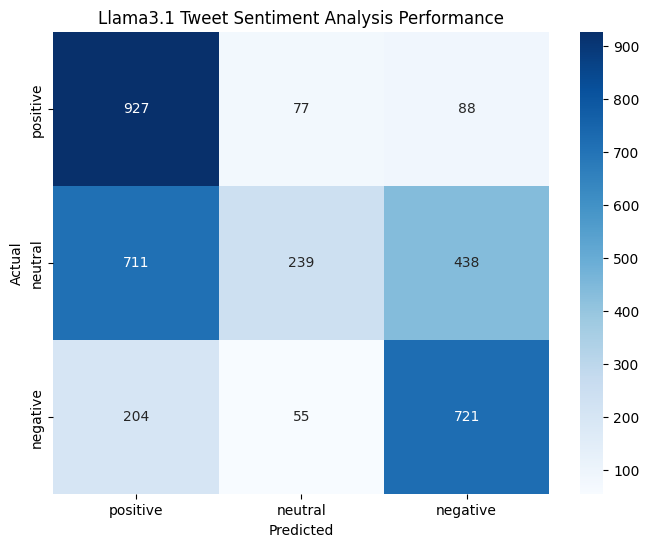

Accuracy: 53.40%
Class 0: Precision=0.5033, Recall=0.8489, IoU=0.4619, F1 Score=0.6319
Class 1: Precision=0.6442, Recall=0.1722, IoU=0.1572, F1 Score=0.2717
Class 2: Precision=0.5782, Recall=0.7357, IoU=0.4788, F1 Score=0.6475

Average Precision: 0.5752
Average Recall: 0.5856
Average IoU: 0.3660
Average F1 Score: 0.5171
AUC (based on Precision-Recall curve): 0.4056


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import auc, precision_recall_curve


df = pd.read_csv('test0_1.csv')
df.columns = ['Correct', 'Predicted', 'Actual', 'Sample', 'Output']
print(set(df['Predicted']))
num_removed = df[df['Predicted'] == '-1'].shape[0]
outputsDF = df[df['Predicted'] != '-1'].copy()
print(f"Number of rows removed due to 'Predicted' value being -1: {num_removed}")

sentiments = ['positive', 'neutral', 'negative']
confusion_matrix = pd.DataFrame(np.zeros((3, 3), dtype=int), index=sentiments, columns=sentiments)

# Populate the confusion matrix
for _, row in outputsDF.iterrows():
    actual = row['Actual']
    predicted = row['Predicted']
    confusion_matrix.loc[actual, predicted] += 1

# Plot the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.title('Llama3.1 Tweet Sentiment Analysis Performance')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

correct_predictions = (outputsDF['Predicted'] == outputsDF['Actual']).sum()
total_predictions = len(df)                             #Using DF instead of outputsDF to factor in the ones that it did not properly answer the question
accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy:.2%}')


def calculate_metrics(conf_matrix):
    num_classes = conf_matrix.shape[0]
    
    # Initialize lists to store precision, recall, IoU, F1
    precision_list = []
    recall_list = []
    iou_list = []
    f1_list = []
    
    for i in range(num_classes):
        TP = conf_matrix.iloc[i, i]  # True positives for class i
        FP = conf_matrix.iloc[:, i].sum() - TP  # False positives for class i
        FN = conf_matrix.iloc[i, :].sum() - TP  # False negatives for class i
        TN = conf_matrix.sum().sum() - (TP + FP + FN)  # True negatives (not used directly)
        
        # Precision, recall, IoU for class i
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
        
        # F1 Score for class i
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precision_list.append(precision)
        recall_list.append(recall)
        iou_list.append(iou)
        f1_list.append(f1_score)
        
        print(f"Class {i}: Precision={precision:.4f}, Recall={recall:.4f}, IoU={iou:.4f}, F1 Score={f1_score:.4f}")
    
    # Average precision, recall, IoU, and F1 across classes
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_iou = np.mean(iou_list)
    avg_f1 = np.mean(f1_list)
    
    print(f"\nAverage Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    
    return precision_list, recall_list, iou_list, f1_list

def calculate_auc(precision, recall):
    # To calculate AUC, we need to sort precision and recall
    sorted_indices = np.argsort(recall)
    sorted_recall = np.array(recall)[sorted_indices]
    sorted_precision = np.array(precision)[sorted_indices]
    
    # Calculate AUC using trapezoidal rule (area under Precision-Recall curve)
    auc_score = auc(sorted_recall, sorted_precision)
    print(f"AUC (based on Precision-Recall curve): {auc_score:.4f}")
    
    return auc_score

# Call the updated functions
precision_list, recall_list, iou_list, f1_list = calculate_metrics(confusion_matrix)
auc_score = calculate_auc(precision_list, recall_list)


{'neutral', 'negative', '-1', 'positive'}
Number of rows removed due to 'Predicted' value being -1: 88


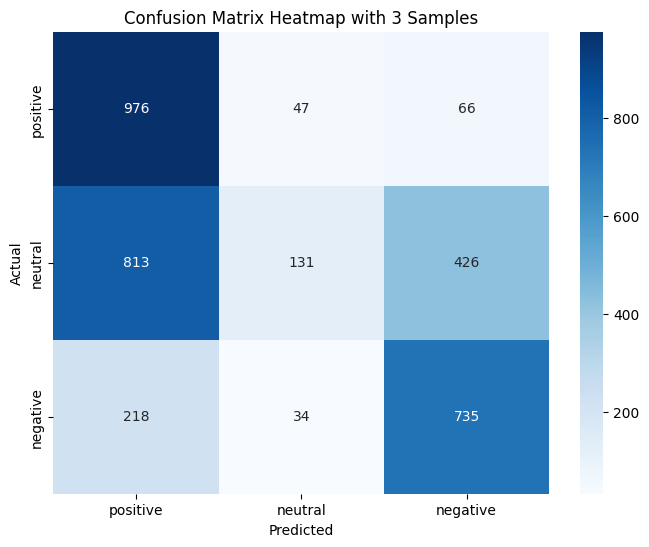

Accuracy: 52.12%
Class 0: Precision=0.4863, Recall=0.8962, IoU=0.4604, F1 Score=0.6305
Class 1: Precision=0.6179, Recall=0.0956, IoU=0.0903, F1 Score=0.1656
Class 2: Precision=0.5990, Recall=0.7447, IoU=0.4970, F1 Score=0.6640

Average Precision: 0.5677
Average Recall: 0.5788
Average IoU: 0.3492
Average F1 Score: 0.4867
AUC (based on Precision-Recall curve): 0.4772


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('test0_1_multishot_3.csv')
df.columns = ['Correct', 'Predicted', 'Actual', 'Sample', 'Output']
print(set(df['Predicted']))
num_removed = df[df['Predicted'] == '-1'].shape[0]
outputsDF = df[df['Predicted'] != '-1'].copy()
print(f"Number of rows removed due to 'Predicted' value being -1: {num_removed}")

sentiments = ['positive', 'neutral', 'negative']
confusion_matrix = pd.DataFrame(np.zeros((3, 3), dtype=int), index=sentiments, columns=sentiments)

# Populate the confusion matrix
for _, row in outputsDF.iterrows():
    actual = row['Actual']
    predicted = row['Predicted']
    confusion_matrix.loc[actual, predicted] += 1

# Plot the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.title('Confusion Matrix Heatmap with 3 Samples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

correct_predictions = (outputsDF['Predicted'] == outputsDF['Actual']).sum()
total_predictions = len(df)                             #Using DF instead of outputsDF to factor in the ones that it did not properly answer the question
accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy:.2%}')

# Call the updated functions
precision_list, recall_list, iou_list, f1_list = calculate_metrics(confusion_matrix)
auc_score = calculate_auc(precision_list, recall_list)


{'neutral', 'negative', '-1', 'positive'}
Number of rows removed due to 'Predicted' value being -1: 144


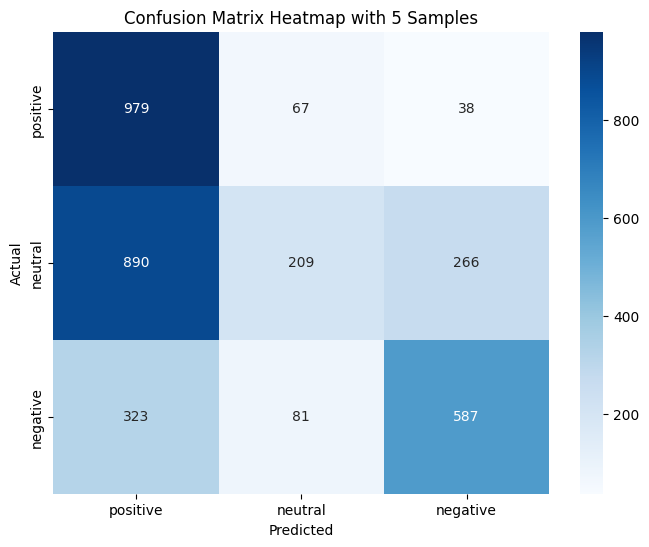

Accuracy: 49.53%
Class 0: Precision=0.4466, Recall=0.9031, IoU=0.4262, F1 Score=0.5977
Class 1: Precision=0.5854, Recall=0.1531, IoU=0.1381, F1 Score=0.2427
Class 2: Precision=0.6588, Recall=0.5923, IoU=0.4533, F1 Score=0.6238

Average Precision: 0.5636
Average Recall: 0.5495
Average IoU: 0.3392
Average F1 Score: 0.4881
AUC (based on Precision-Recall curve): 0.4450


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('test0_1_multishot_5.csv')
df.columns = ['Correct', 'Predicted', 'Actual', 'Sample', 'Output']
print(set(df['Predicted']))
num_removed = df[df['Predicted'] == '-1'].shape[0]
outputsDF = df[df['Predicted'] != '-1'].copy()
print(f"Number of rows removed due to 'Predicted' value being -1: {num_removed}")

sentiments = ['positive', 'neutral', 'negative']
confusion_matrix = pd.DataFrame(np.zeros((3, 3), dtype=int), index=sentiments, columns=sentiments)

# Populate the confusion matrix
for _, row in outputsDF.iterrows():
    actual = row['Actual']
    predicted = row['Predicted']
    confusion_matrix.loc[actual, predicted] += 1

# Plot the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.title('Confusion Matrix Heatmap with 5 Samples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

correct_predictions = (outputsDF['Predicted'] == outputsDF['Actual']).sum()
total_predictions = len(df)                             #Using DF instead of outputsDF to factor in the ones that it did not properly answer the question
accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy:.2%}')

# Call the updated functions
precision_list, recall_list, iou_list, f1_list = calculate_metrics(confusion_matrix)
auc_score = calculate_auc(precision_list, recall_list)


{'neutral', 'negative', '-1', 'positive'}
Number of rows removed due to 'Predicted' value being -1: 98


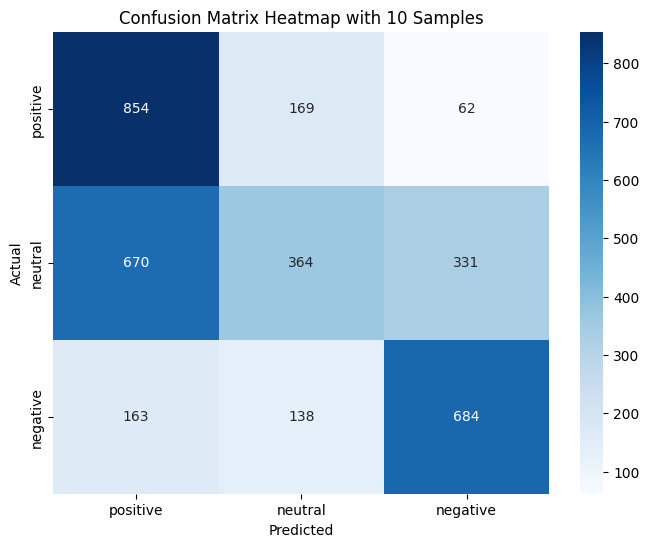

Accuracy: 53.84%
Class 0: Precision=0.5062, Recall=0.7871, IoU=0.4453, F1 Score=0.6162
Class 1: Precision=0.5425, Recall=0.2667, IoU=0.2177, F1 Score=0.3576
Class 2: Precision=0.6351, Recall=0.6944, IoU=0.4964, F1 Score=0.6634

Average Precision: 0.5613
Average Recall: 0.5827
Average IoU: 0.3864
Average F1 Score: 0.5457
AUC (based on Precision-Recall curve): 0.3047


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('test0_1_multishot_10.csv')
df.columns = ['Correct', 'Predicted', 'Actual', 'Sample', 'Output']
print(set(df['Predicted']))
num_removed = df[df['Predicted'] == '-1'].shape[0]
outputsDF = df[df['Predicted'] != '-1'].copy()
print(f"Number of rows removed due to 'Predicted' value being -1: {num_removed}")

sentiments = ['positive', 'neutral', 'negative']
confusion_matrix = pd.DataFrame(np.zeros((3, 3), dtype=int), index=sentiments, columns=sentiments)

# Populate the confusion matrix
for _, row in outputsDF.iterrows():
    actual = row['Actual']
    predicted = row['Predicted']
    confusion_matrix.loc[actual, predicted] += 1

# Plot the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.title('Confusion Matrix Heatmap with 10 Samples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

correct_predictions = (outputsDF['Predicted'] == outputsDF['Actual']).sum()
total_predictions = len(df)                             #Using DF instead of outputsDF to factor in the ones that it did not properly answer the question
accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy:.2%}')

# Call the updated functions
precision_list, recall_list, iou_list, f1_list = calculate_metrics(confusion_matrix)
auc_score = calculate_auc(precision_list, recall_list)


{'neutral', 'negative', '-1', 'positive'}
Number of rows removed due to 'Predicted' value being -1: 69


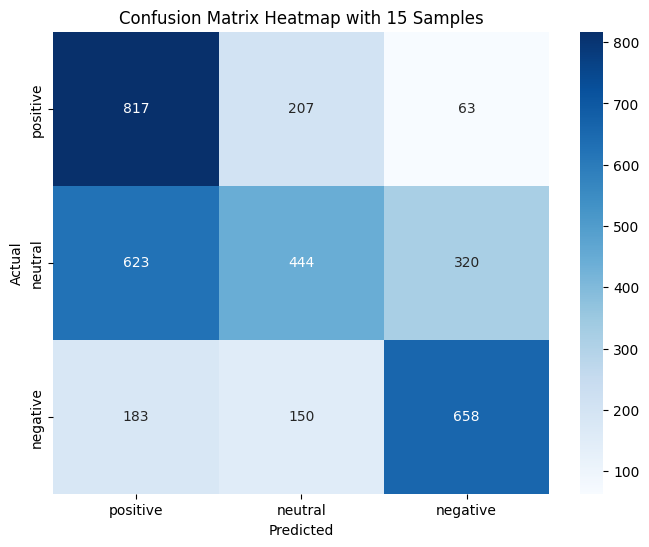

Accuracy: 54.30%
Class 0: Precision=0.5034, Recall=0.7516, IoU=0.4316, F1 Score=0.6030
Class 1: Precision=0.5543, Recall=0.3201, IoU=0.2546, F1 Score=0.4059
Class 2: Precision=0.6321, Recall=0.6640, IoU=0.4789, F1 Score=0.6476

Average Precision: 0.5633
Average Recall: 0.5786
Average IoU: 0.3884
Average F1 Score: 0.5521
AUC (based on Precision-Recall curve): 0.2537


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('test0_1_multishot_15.csv')
df.columns = ['Correct', 'Predicted', 'Actual', 'Sample', 'Output']
print(set(df['Predicted']))
num_removed = df[df['Predicted'] == '-1'].shape[0]
outputsDF = df[df['Predicted'] != '-1'].copy()
print(f"Number of rows removed due to 'Predicted' value being -1: {num_removed}")

sentiments = ['positive', 'neutral', 'negative']
confusion_matrix = pd.DataFrame(np.zeros((3, 3), dtype=int), index=sentiments, columns=sentiments)

# Populate the confusion matrix
for _, row in outputsDF.iterrows():
    actual = row['Actual']
    predicted = row['Predicted']
    confusion_matrix.loc[actual, predicted] += 1

# Plot the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.title('Confusion Matrix Heatmap with 15 Samples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

correct_predictions = (outputsDF['Predicted'] == outputsDF['Actual']).sum()
total_predictions = len(df)                             #Using DF instead of outputsDF to factor in the ones that it did not properly answer the question
accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy:.2%}')

# Call the updated functions
precision_list, recall_list, iou_list, f1_list = calculate_metrics(confusion_matrix)
auc_score = calculate_auc(precision_list, recall_list)


{'neutral', 'negative', '-1', 'positive'}
Number of rows removed due to 'Predicted' value being -1: 3


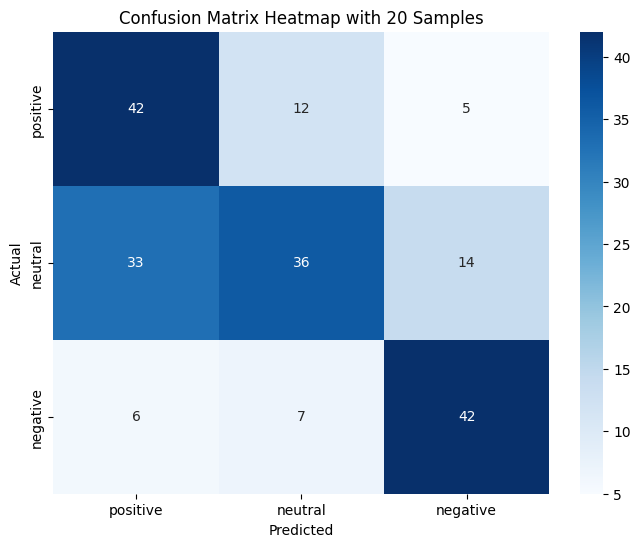

Accuracy: 60.00%
Class 0: Precision=0.5185, Recall=0.7119, IoU=0.4286, F1 Score=0.6000
Class 1: Precision=0.6545, Recall=0.4337, IoU=0.3529, F1 Score=0.5217
Class 2: Precision=0.6885, Recall=0.7636, IoU=0.5676, F1 Score=0.7241

Average Precision: 0.6205
Average Recall: 0.6364
Average IoU: 0.4497
Average F1 Score: 0.6153
AUC (based on Precision-Recall curve): 0.1944


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('test0_1_multishot_20.csv')
df.columns = ['Correct', 'Predicted', 'Actual', 'Sample', 'Output']
print(set(df['Predicted']))
num_removed = df[df['Predicted'] == '-1'].shape[0]
outputsDF = df[df['Predicted'] != '-1'].copy()
print(f"Number of rows removed due to 'Predicted' value being -1: {num_removed}")

sentiments = ['positive', 'neutral', 'negative']
confusion_matrix = pd.DataFrame(np.zeros((3, 3), dtype=int), index=sentiments, columns=sentiments)

# Populate the confusion matrix
for _, row in outputsDF.iterrows():
    actual = row['Actual']
    predicted = row['Predicted']
    confusion_matrix.loc[actual, predicted] += 1

# Plot the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.title('Confusion Matrix Heatmap with 20 Samples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

correct_predictions = (outputsDF['Predicted'] == outputsDF['Actual']).sum()
total_predictions = len(df)                             #Using DF instead of outputsDF to factor in the ones that it did not properly answer the question
accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy:.2%}')

# Call the updated functions
precision_list, recall_list, iou_list, f1_list = calculate_metrics(confusion_matrix)
auc_score = calculate_auc(precision_list, recall_list)


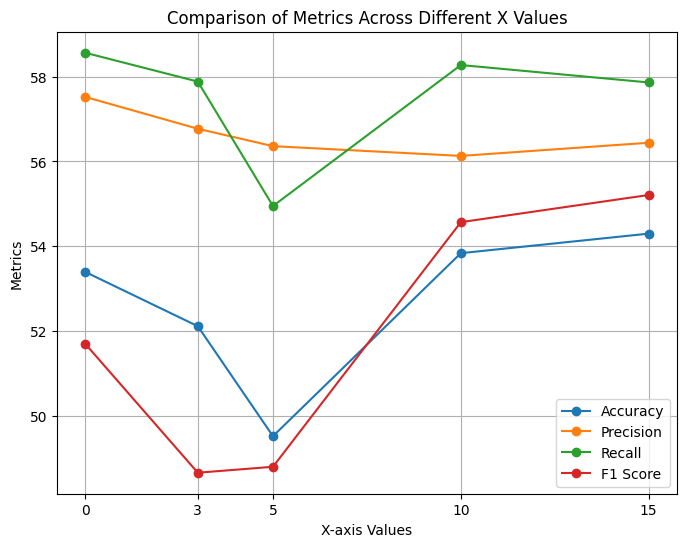

In [3]:
import matplotlib.pyplot as plt

accuracy = [53.40, 52.12, 49.53, 53.84, 54.3]
precision = [57.52, 56.77, 56.36, 56.13, 56.44]
recall = [58.56, 57.88, 54.95, 58.27, 57.86]
f1 = [51.71, 48.67, 48.81, 54.57, 55.21]


# Data
x = [0, 3, 5, 10, 15]

plt.figure(figsize=(8, 6))
plt.plot(x, accuracy, label='Accuracy', marker='o')
plt.plot(x, precision, label='Precision', marker='o')
plt.plot(x, recall, label='Recall', marker='o')
plt.plot(x, f1, label='F1 Score', marker='o')

# Labels and title
plt.xlabel('X-axis Values')
plt.ylabel('Metrics')
plt.title('Comparison of Metrics Across Different X Values')
plt.xticks([0, 3, 5, 10, 15])  # Set specific ticks on x-axis
plt.legend()
plt.grid(True)
plt.show()